In [1]:
import numpy as np
from matplotlib import pyplot as plt
from pulse_pair_doppler import pulse_pair_doppler

In [11]:
# TODO add satellite motion
# FIXME Does scatterers follow rayleight before or after incidence-angle dependence?

model = pulse_pair_doppler(
    t_pulse=1e-4,                   # s
    t_receive=100e-4,                # s 
    t_interpulse=0*1e-4,              # s
    # n_reflectors=40,            # -    TODO why does this number increase error?
    n_pulses=2,                     # -
    n_bursts=35,                    # -
    bandwidth=1e6,                  # hz
    baseband=0*5.405e9,             # hz   TODO why does this number increase error?
    oversample_retriev=1,           # -    TODO why does this number increase error?
    range_cell_avg_factor=1,        # -
    range_cell_size_frac_pulse=1,   # -
    seed=12,                         # -
)

# Single Burst

In [12]:
model.chirp(centre_around_baseband=True)
model.pulse_pairs()
model.simulate_reflection()
model.pulse_compress(window_function=False)
model.delayed_autocorrelation()
model.phase_difference()

Autocorrelation cell: 100%|██████████| 96/96 [00:00<00:00, 21897.61it/s]


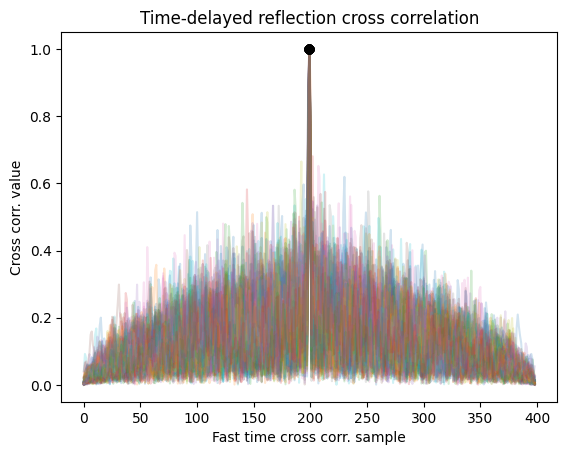

In [13]:
sig = abs(model.corr.T)
sig /= np.max(sig, axis = 0)
peaks = np.argmax(sig, axis = 0)

plt.figure()
plt.title("Time-delayed reflection cross correlation"); plt.xlabel("Fast time cross corr. sample"); plt.ylabel("Cross corr. value"); 
plt.plot(sig, alpha = 0.2, zorder = 1)
plt.scatter(peaks, sig[peaks, np.arange(len(model.corr))], c = 'k', zorder =2)

In [14]:
if model.n_reflectors is not None:
    arb_cross_corr_limit = np.min(np.sort(np.max(sig, axis = 0), axis=0)[-model.n_reflectors:])
    phase_diff = model.phase_diff_avg_rg[sig.max(axis= 0) >= arb_cross_corr_limit]
else:
    phase_diff = model.phase_diff_avg_rg

phase_diff_rmse = np.sqrt(np.mean(phase_diff**2))

c = 3e8 # m/s
Lambda = 0.05 # c/f # m
t_delta = model.t_pulse + model.t_interpulse

LoS_velocity_phase = phase_diff * Lambda / (2*np.pi * t_delta)
LoS_velocity_phase_rmse = phase_diff_rmse * Lambda / (2*np.pi * t_delta)

print(f"\n RMSE phase error of: {phase_diff_rmse:.4f} rad, which is equal to {LoS_velocity_phase_rmse:.3f} m/s ")


 RMSE phase error of: 0.1445 rad, which is equal to 11.495 m/s 


# Multi burst

In [15]:
model.azimuth_average(window_function=False)

Burst number: 100%|██████████| 35/35 [00:00<00:00, 154.20it/s]


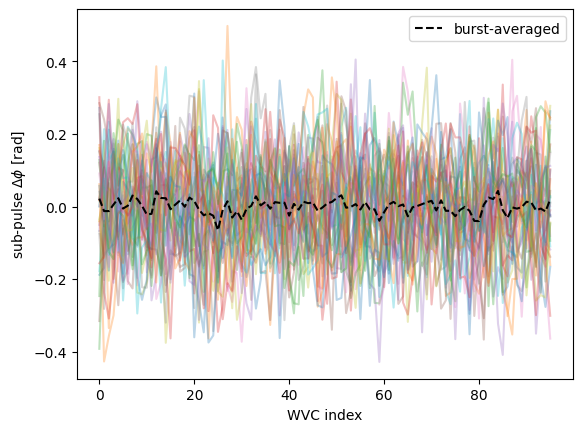

In [16]:
plt.plot(model.phase_diff_avg_rg.T, alpha = 0.3)
plt.plot(model.phase_diffs_avg_rg_az, 'k--', label = 'burst-averaged')
plt.xlabel('WVC index'); plt.ylabel('sub-pulse $\Delta \phi$ [rad]')
plt.legend()

In [17]:
phase_diff = model.phase_diffs_avg_rg_az[:]

phase_diff_rmse = np.sqrt(np.mean(phase_diff**2))

c = 3e8 # m/s
Lambda = 0.05 #c/f # m
t_delta = model.t_pulse + model.t_interpulse

LoS_velocity_phase = phase_diff * Lambda / (2*np.pi * t_delta)
LoS_velocity_phase_rmse = phase_diff_rmse * Lambda / (2*np.pi * t_delta)

print(f"\n RMSE phase error of: {phase_diff_rmse:.4f} rad, which is equal to {LoS_velocity_phase_rmse:.3f} m/s ")


 RMSE phase error of: 0.0188 rad, which is equal to 1.499 m/s 


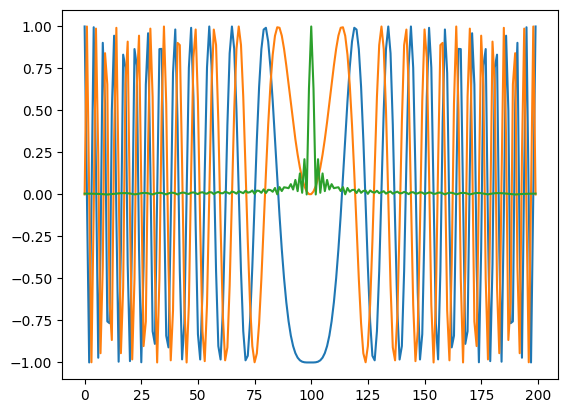

In [23]:
from scipy.signal import correlate, fftconvolve
aa = model.pulse
bb = model.pulse * np.exp(1j*2*np.pi*0.25)
aap = np.arctan2(aa.imag, aa.real)
bbp = np.arctan2(bb.imag, bb.real)

plt.plot(aa)
plt.plot(bb)
plt.plot(abs(correlate(aa, bb, mode = 'same'))/len(aa))